In [1]:
#Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, RobustScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import pickle

In [2]:
#Load dataset
def load_data(file_path):
  return pd.read_csv(file_path)

In [3]:
#Data cleaning
def clean_data(data):
  print(f'Missing values:\n{data.isnull().sum()}')   #Check for missing values
  print('\nDuplicates:', data.duplicated().sum())  #Check for duplicates

Since there are no missing values and duplicates in the dataset, there is no need of imputation and duplicate removal.

In [4]:
#Perform Exploratory Data Analysis
def perform_eda(data):
  print(f'\nNumber of unique values:\n{data.nunique()}\n')  #Check for unique values
  print(data.info())  #Information about the dataset
  print(f'\nStatistical summary:\n{data.describe()}\n')  #Statistical summary

In [5]:
#Knowledge Representation by visualizing the data
def data_visualization(data):
  #Histogram
  data.hist(bins=20, figsize=(20, 15))
  plt.show()

  #Correlation heatmap
  plt.figure(figsize=(6, 6))
  sns.heatmap(data.drop('Crop', axis=1).corr(), annot=True, cbar=True)
  plt.show()

  #Plotting crop distribution
  melt_data = data.melt(id_vars=['Crop'], value_vars=['Nitrogen', 'Phosphorus', 'Potassium',
                                                         'Temperature', 'Humidity', 'pH_Value',
                                                         'Rainfall'],

                        var_name='feature', value_name='value')
  plt.figure(figsize=(24, 8))
  sns.barplot(x='Crop', y='value', hue='feature', data=melt_data, palette='Spectral', dodge=True)

  #Plotting feature requirements for each crop
  plt.title('Crop Distribution by Feature')
  crops = data['Crop'].unique()
  for crop in crops:
    crop_data = melt_data[melt_data['Crop'] == crop]
    plt.figure(figsize=(7, 4))
    sns.barplot(hue='feature', x='feature', y='value', data=crop_data, palette='Spectral', legend=False)
    plt.title(f'Optimal requirements for {crop}')
    plt.xlabel('Features')
    plt.ylabel('Value')
    plt.tight_layout()
    plt.show()

  #Boxplot for each feature
  features = data.drop('Crop', axis=1)
  for feature in features:
    plt.figure(figsize=(12, 6))
    sns.boxplot(x='Crop', y=feature, data=data, hue='Crop')
    plt.title(f'Boxplot of {feature} by Crop')
    plt.xticks(rotation=90)
    plt.show()

In [6]:
#Preprocessing the data
def preprocess_data(data):
  #Encoding data
  le = LabelEncoder()
  Y = le.fit_transform(data['Crop'])

  #Data normalization by removing median and scaling according to the Inter-Quartile Range
  scaler = RobustScaler()
  features = scaler.fit_transform(data.drop('Crop', axis=1))

  return le, scaler, features, Y

In [7]:
#Pattern identification - training the model
def train_model(X, Y):
  #Split data
  xtrain, xtest, ytrain, ytest = train_test_split(X, Y, test_size=0.2, random_state=42)

  #Train model
  rfc = RandomForestClassifier()
  rfc.fit(xtrain, ytrain)
  y_pred = rfc.predict(xtest)

  #Evaluate model
  print(f'Accuracy: {accuracy_score(ytest, y_pred)}\n')
  print(f'Classification Report:\n {classification_report(ytest, y_pred)}')
  cm = confusion_matrix(ytest, y_pred)
  sns.heatmap(cm, annot=True, cbar=True, cmap='Blues', fmt='d')
  plt.xlabel('Predicted values')
  plt.ylabel('True')
  plt.title('Confusion matrix')
  plt.show()

  #Cross-validation
  score = cross_val_score(rfc, X, Y, cv=5)
  print(f'Cross validation scores:\n{score}')
  print(f'\nMean cross validation score:{score.mean()}')

  return rfc

In [8]:
#Gathering insights - Feature importance
def feature_importance(rfc, X):
  importances = rfc.feature_importances_
  features_names = X.columns
  feature_importance = pd.DataFrame({'feature': features_names, 'importance': importances})
  print(feature_importance.sort_values(by='importance', ascending=False))

  # Plotting feature importances
  plt.figure(figsize(12, 9))
  plt.barplot(x='importance', y='feature', data=feature_importance.sort_values(by='importance', ascending=False))
  plt.show()

In [9]:
#Hyperparameter tuning
def tune_model(rfc, X, Y):
  param_distributions = {
      'n_estimators': [100, 200, 300],
      'max_depth': [10, 20, 30, None],
      'criterion': ['entropy', 'gini'],
      'min_samples_split': [2, 5, 10],
      'min_samples_leaf': [1, 2, 4],
  }

  randomized_search = RandomizedSearchCV(estimator=rfc, param_distributions=param_distributions,
                                           n_iter=50, cv=5, verbose=2, n_jobs=-1, random_state=42)

  randomized_search.fit(X, Y)
  print(f'Best parameters:\n{randomized_search.best_params_}')
  return randomized_search.best_estimator_

In [10]:
#Predictive system
def crop_prediction(rfc, le):
  def get_inputs():
    try:
      Nitrogen = int(input("Amount of Nitrogen: "))
      Phosphorus = int(input("Amount of Phosphorus: "))
      Potassium = int(input("Amount of Potassium: "))
      Temperature = float(input("Temperature: "))
      Humidity = float(input("Humidity: "))
      pH_Value = float(input("pH value: "))
      Rainfall = float(input("Rainfall(in mm): "))
    except ValueError:
      print("Invalid input. Please enter numeric values.")
      return None
    return [Nitrogen, Phosphorus, Potassium, Temperature, Humidity, pH_Value, Rainfall]

    if features is None:
        return

  features = np.array(get_inputs()).reshape(1, -1)
  prediction = rfc.predict(features)

  predicted_crop = le.inverse_transform(prediction)[0]  #Decoding

  if predicted_crop in le.classes_:
    print(f'{predicted_crop} is the best crop to cultivate.')
  else:
    print('Sorry, we are not able to recommend any crop.')

In [11]:
#Function to suggest range of requirements for the inputted crop.
def suggest_crop_requirements(crop_name, data, le, features):

  crop_name = crop_name.strip().capitalize()  # Normalizing the input
  crop_info = data[data['Crop'].str.lower() == crop_name.lower()]

  if crop_name not in le.classes_ or crop_info.empty:
    print(f"Sorry, no information available for {crop_name}.")
    return
  range = {}

  for feature in features:
    min_value = crop_info[feature].min()
    max_value = crop_info[feature].max()

    print(f"{feature}: {min_value} - {max_value}")

In [12]:
# Save model
def save_model(model, filename):
  with open(filename, 'wb') as file:
    pickle.dump(model, file)

# Load model
def load_model(filename):
  with open(filename, 'rb') as file:
    return pickle.load(file)

Missing values:
Nitrogen       0
Phosphorus     0
Potassium      0
Temperature    0
Humidity       0
pH_Value       0
Rainfall       0
Crop           0
dtype: int64

Duplicates: 0

Number of unique values:
Nitrogen        137
Phosphorus      117
Potassium        73
Temperature    2200
Humidity       2200
pH_Value       2200
Rainfall       2200
Crop             22
dtype: int64

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2200 entries, 0 to 2199
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Nitrogen     2200 non-null   int64  
 1   Phosphorus   2200 non-null   int64  
 2   Potassium    2200 non-null   int64  
 3   Temperature  2200 non-null   float64
 4   Humidity     2200 non-null   float64
 5   pH_Value     2200 non-null   float64
 6   Rainfall     2200 non-null   float64
 7   Crop         2200 non-null   object 
dtypes: float64(4), int64(3), object(1)
memory usage: 137.6+ KB
None

Statistical summary:
   

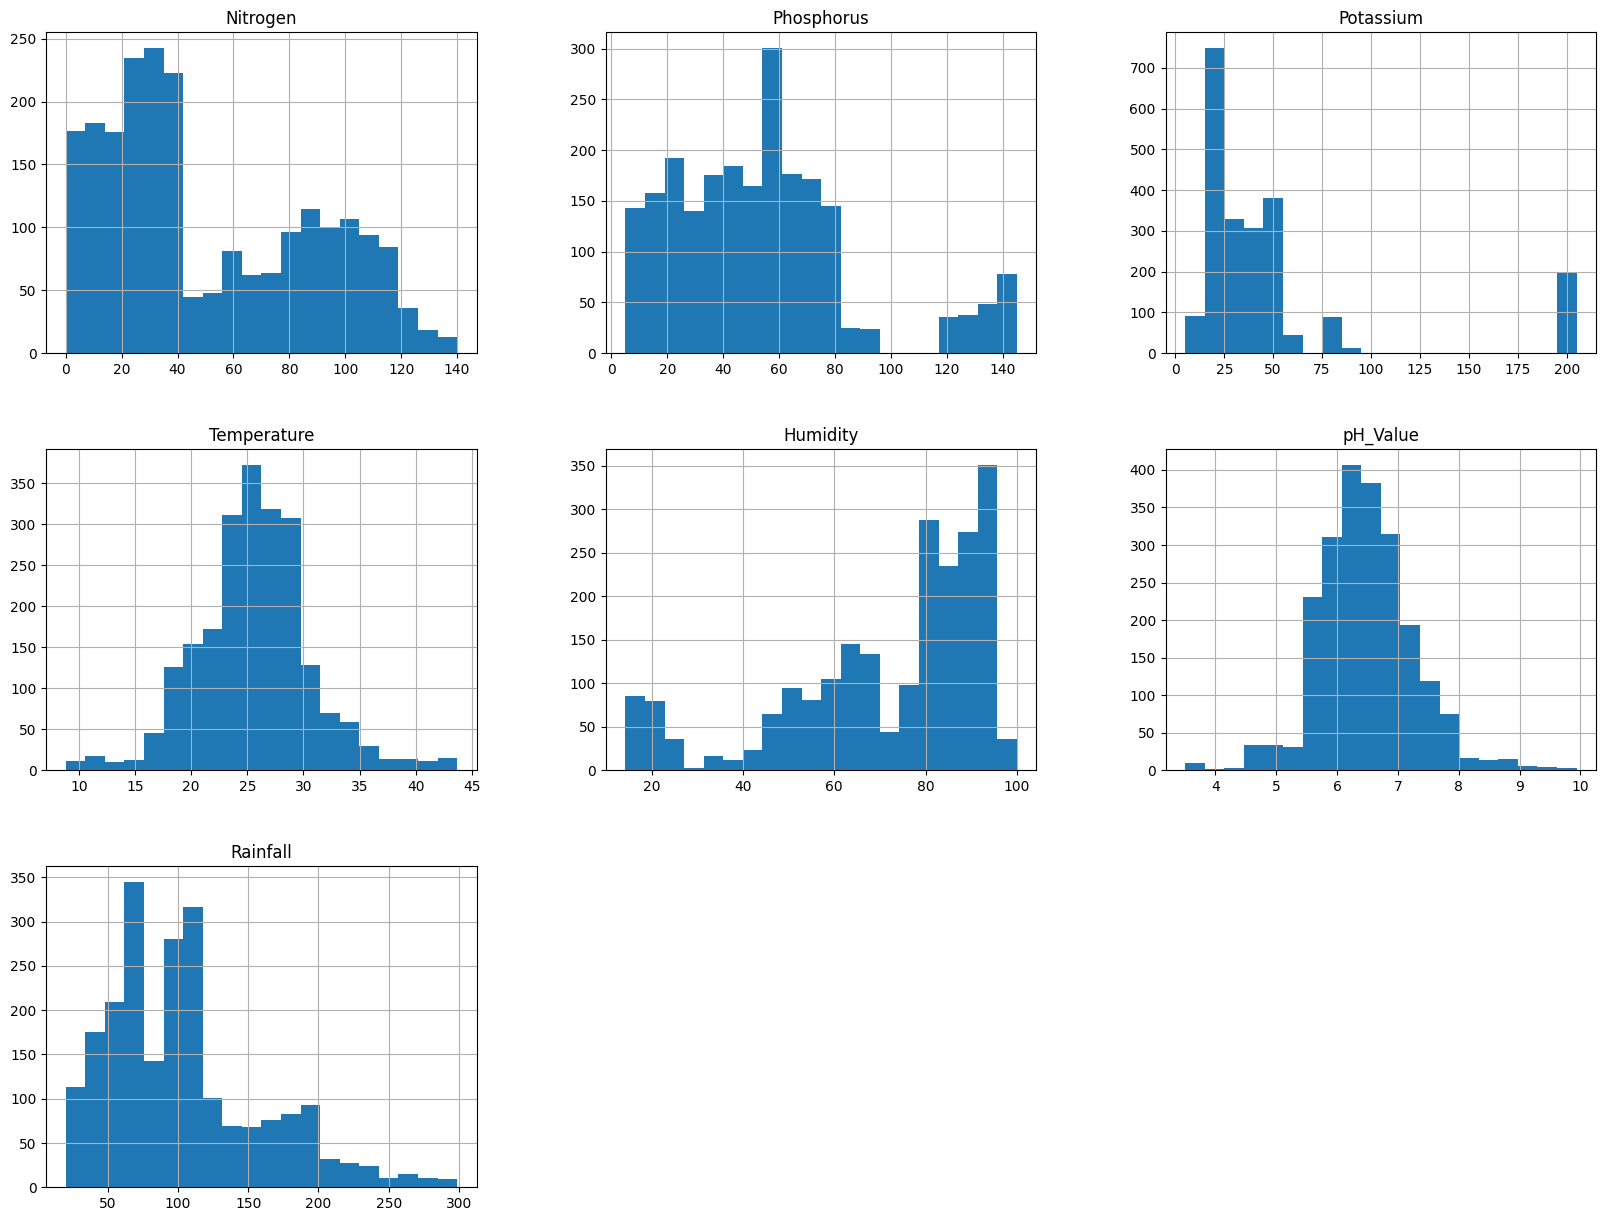

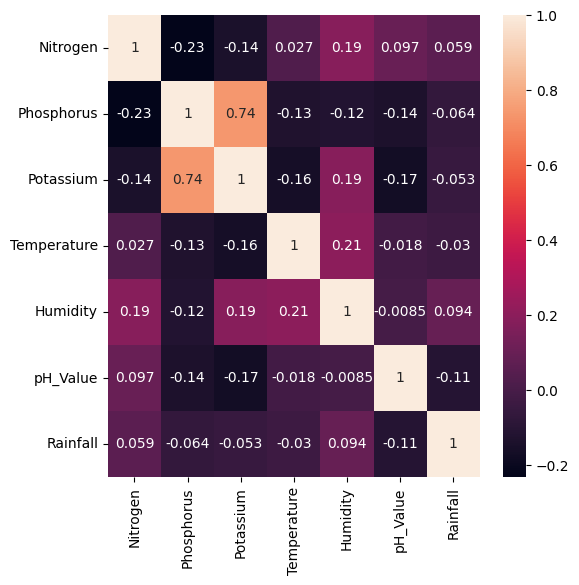

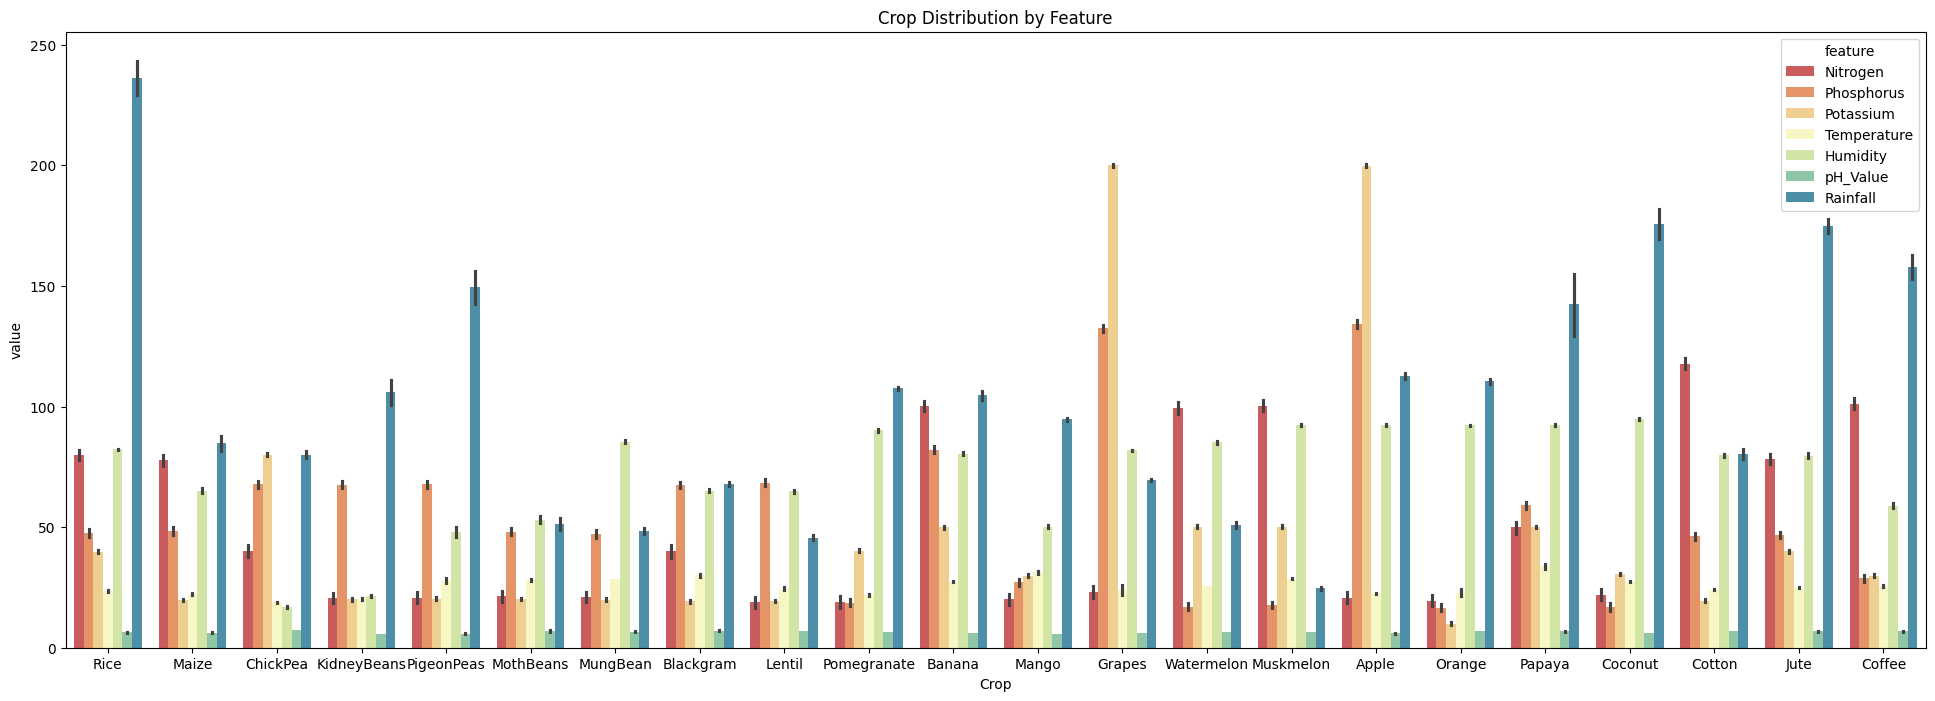

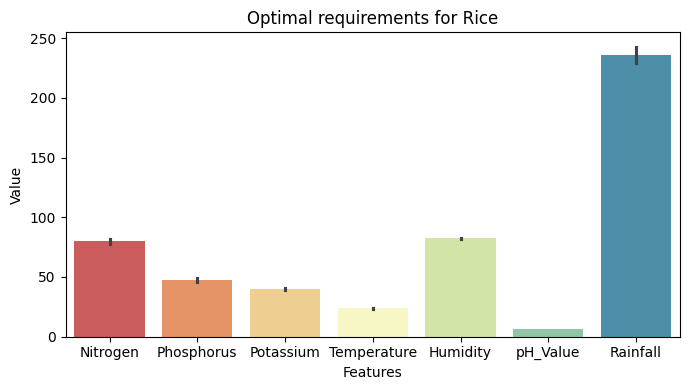

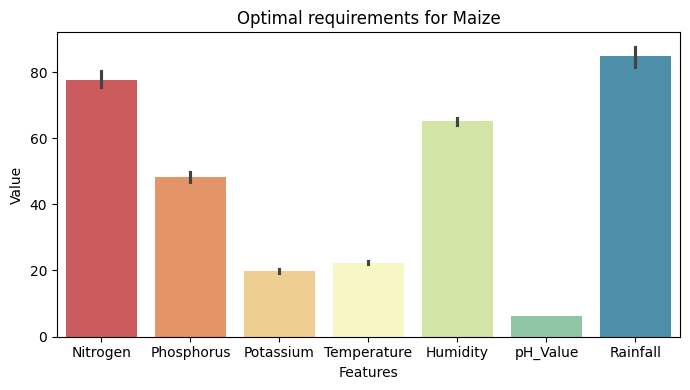

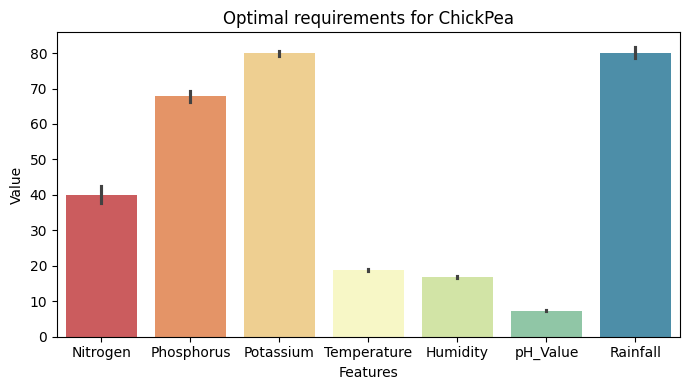

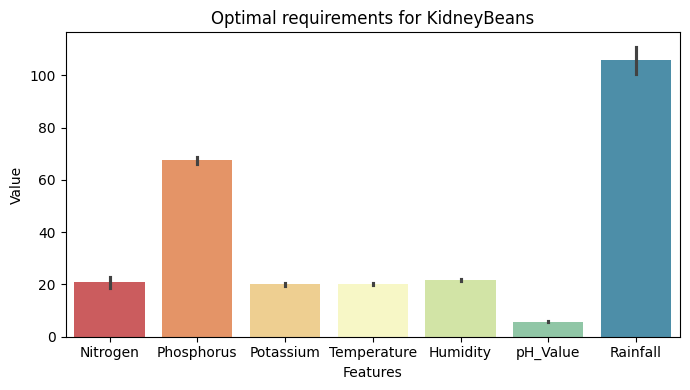

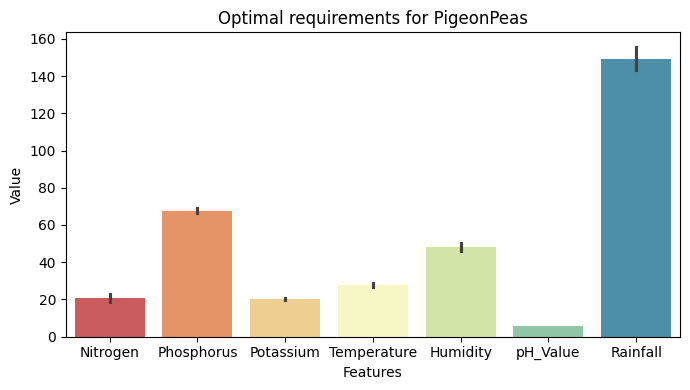

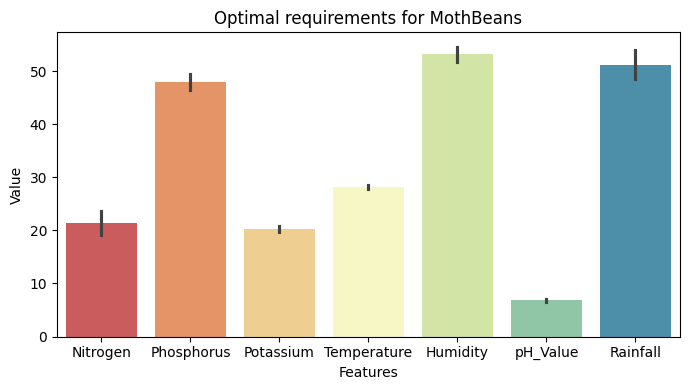

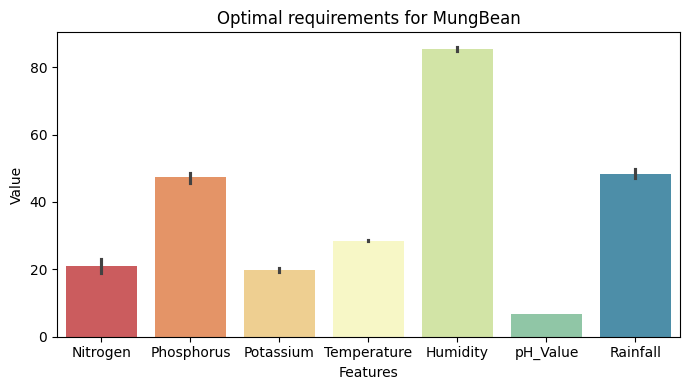

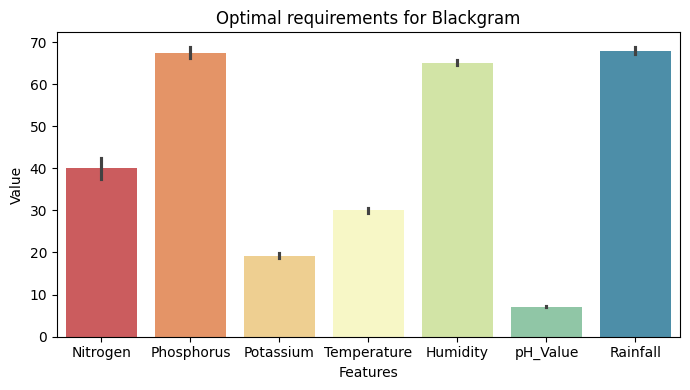

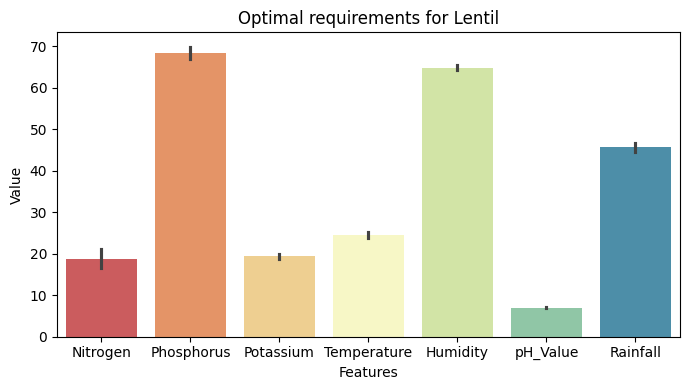

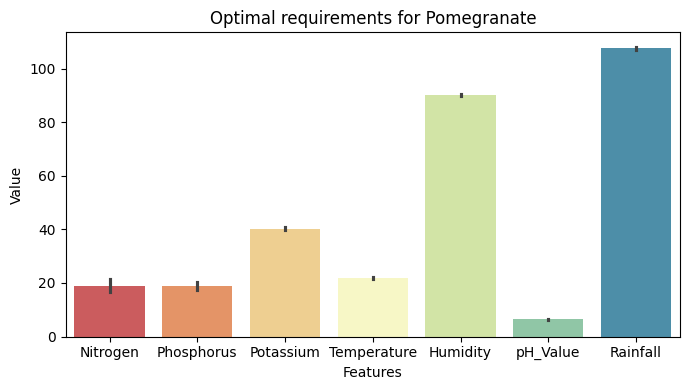

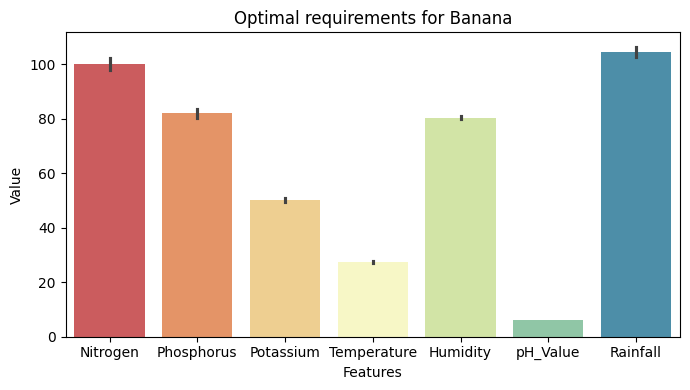

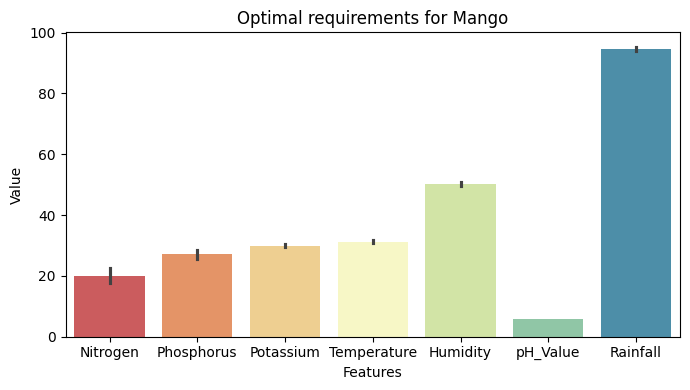

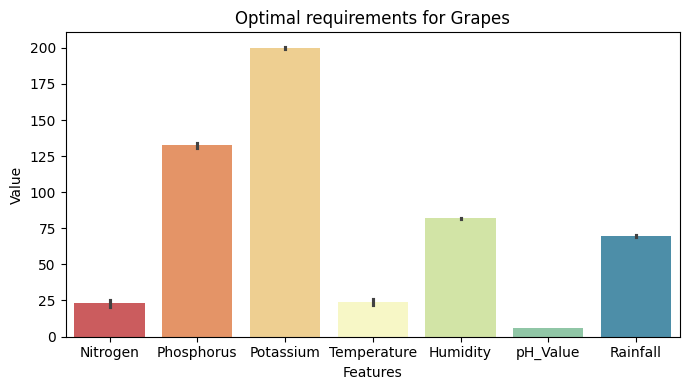

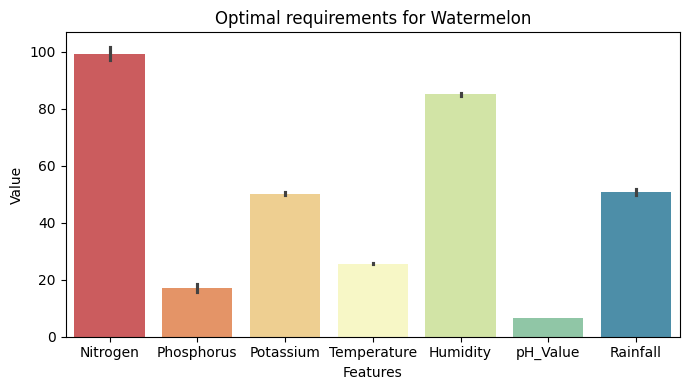

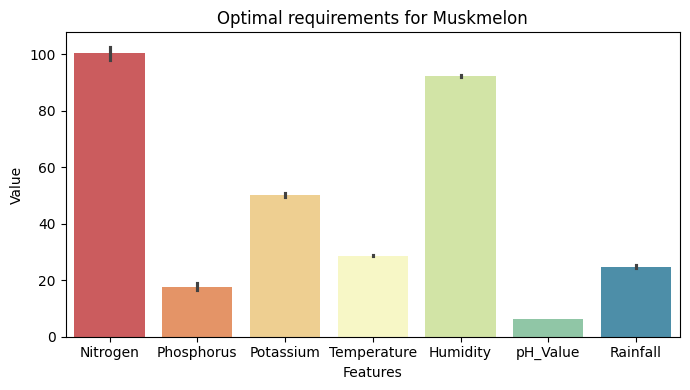

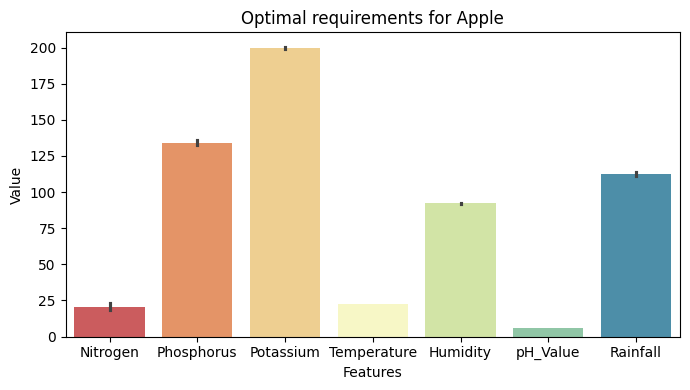

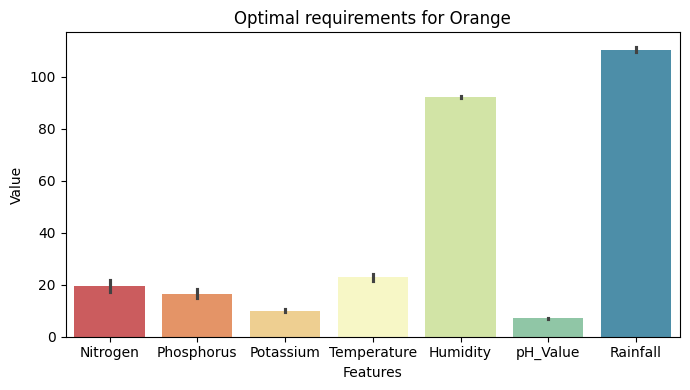

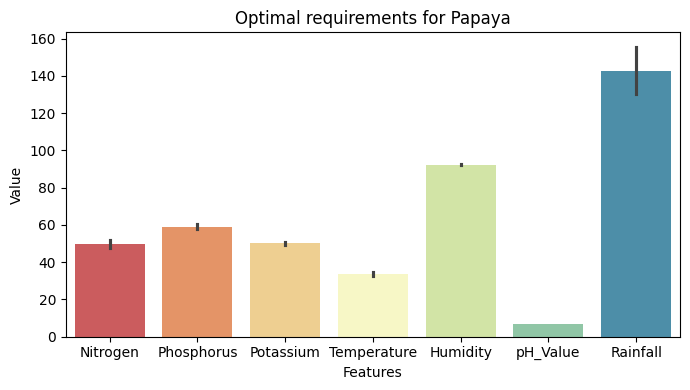

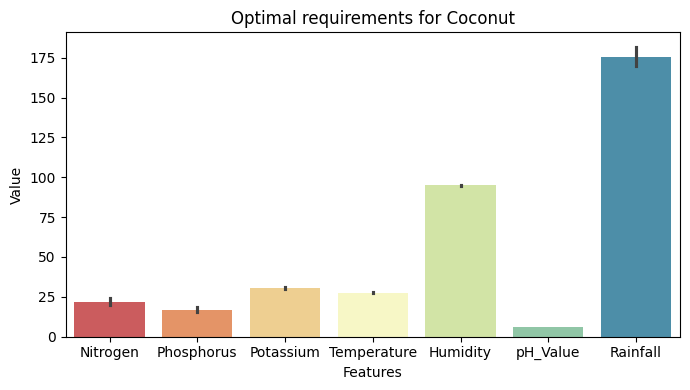

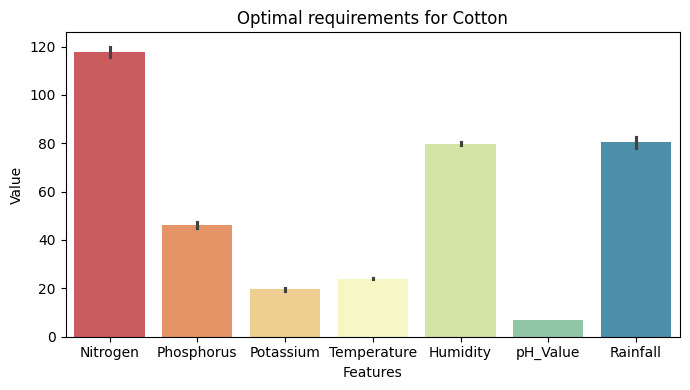

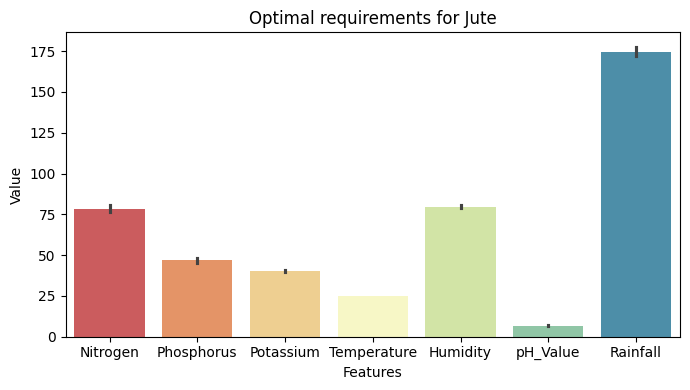

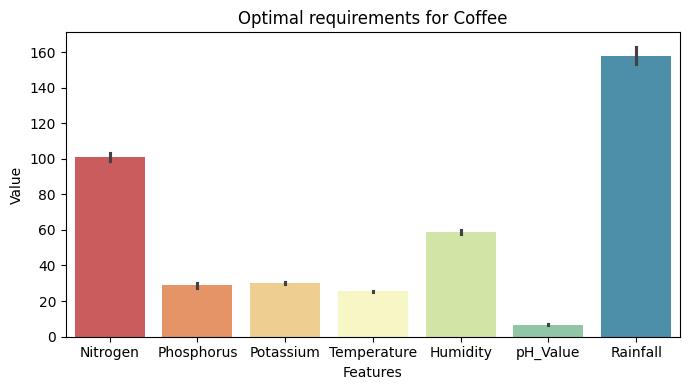

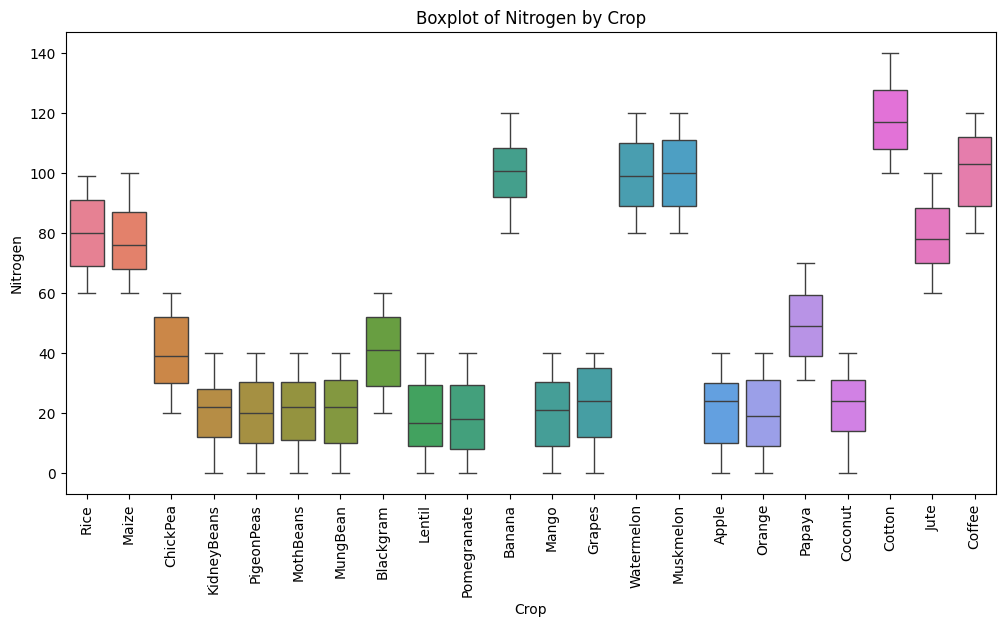

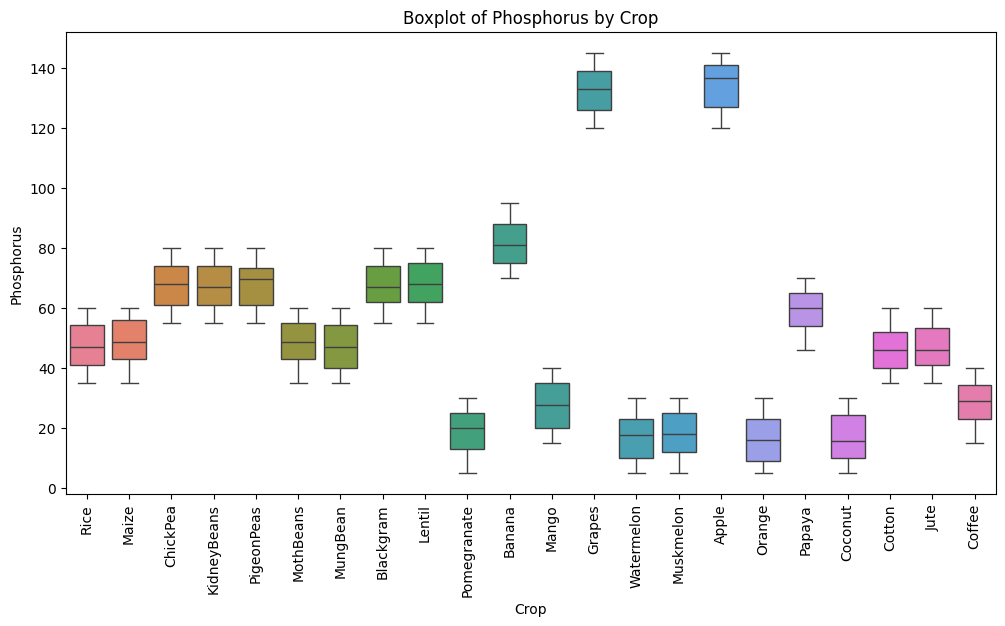

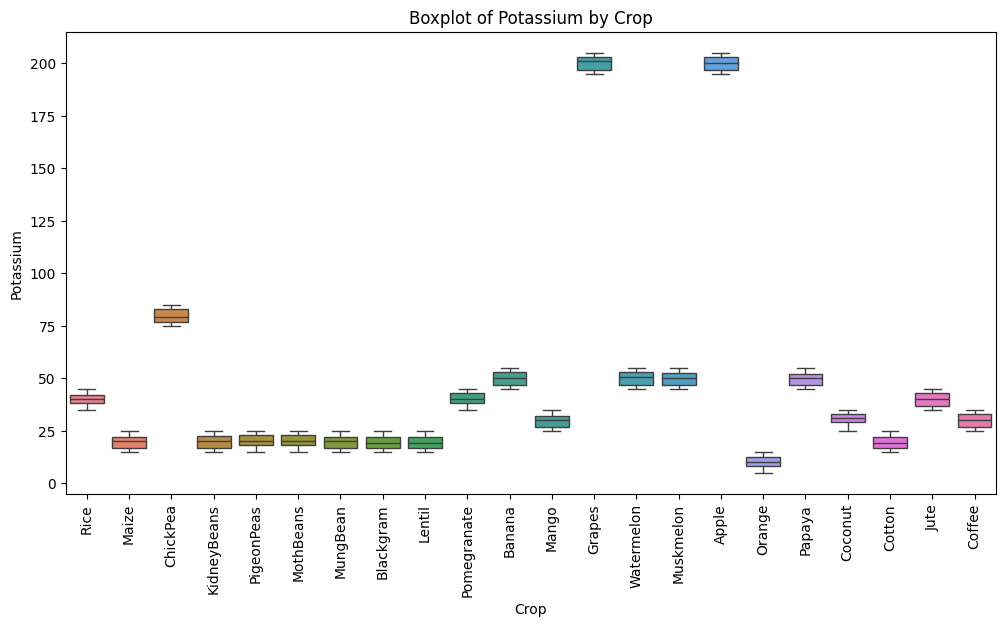

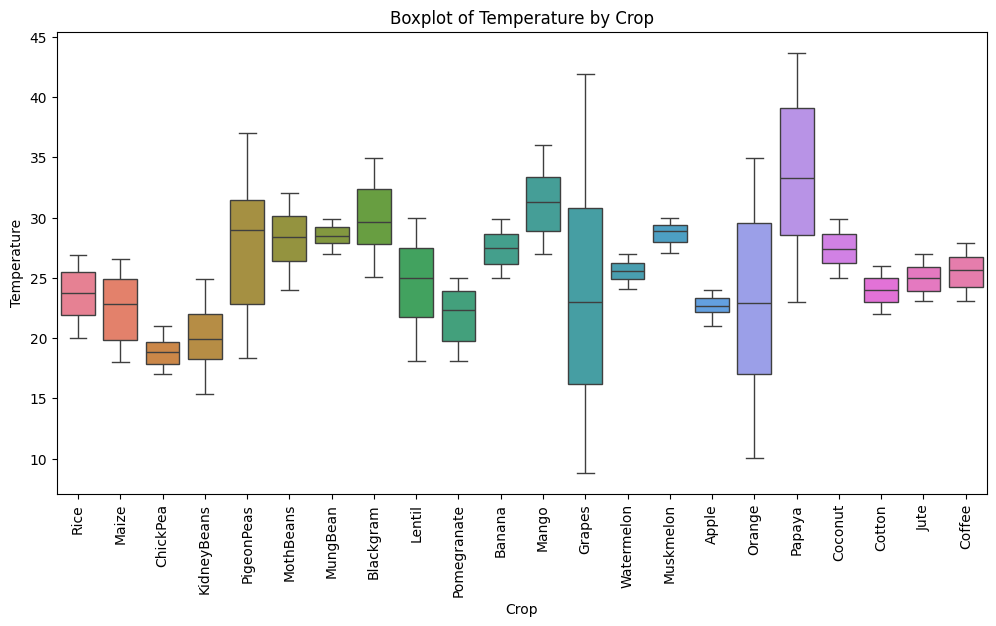

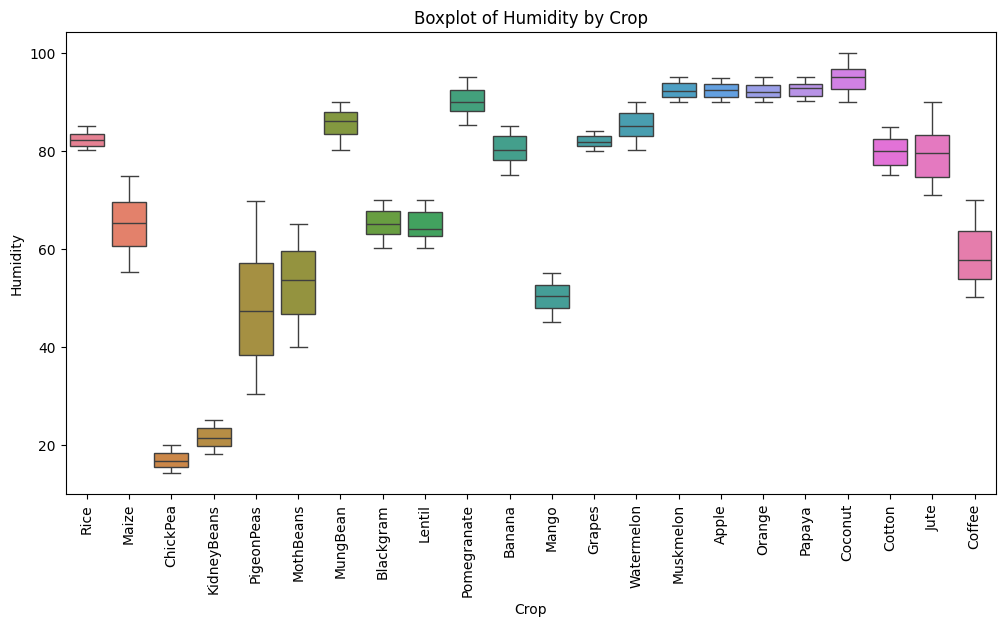

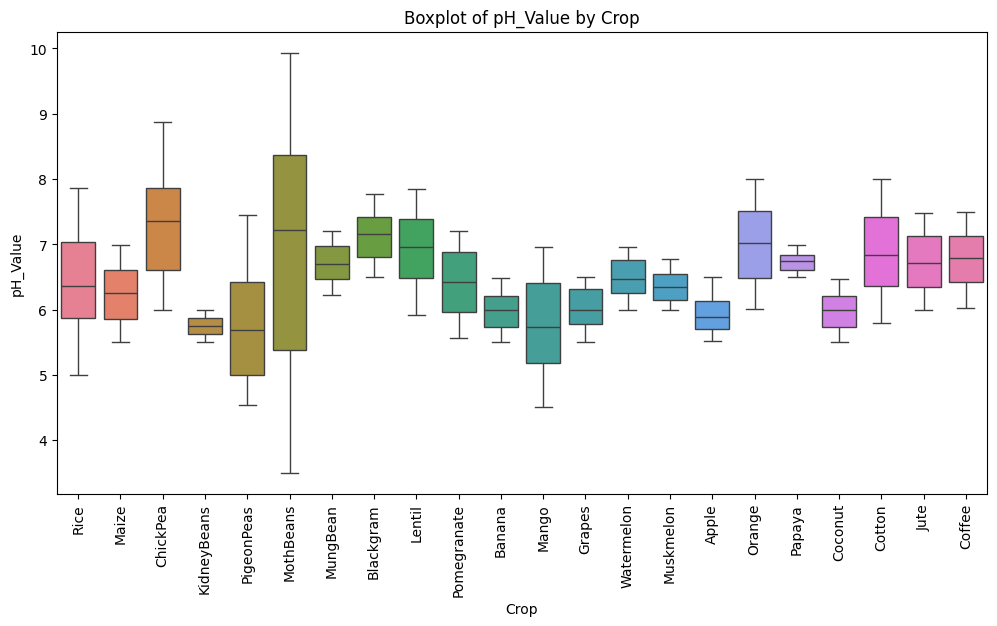

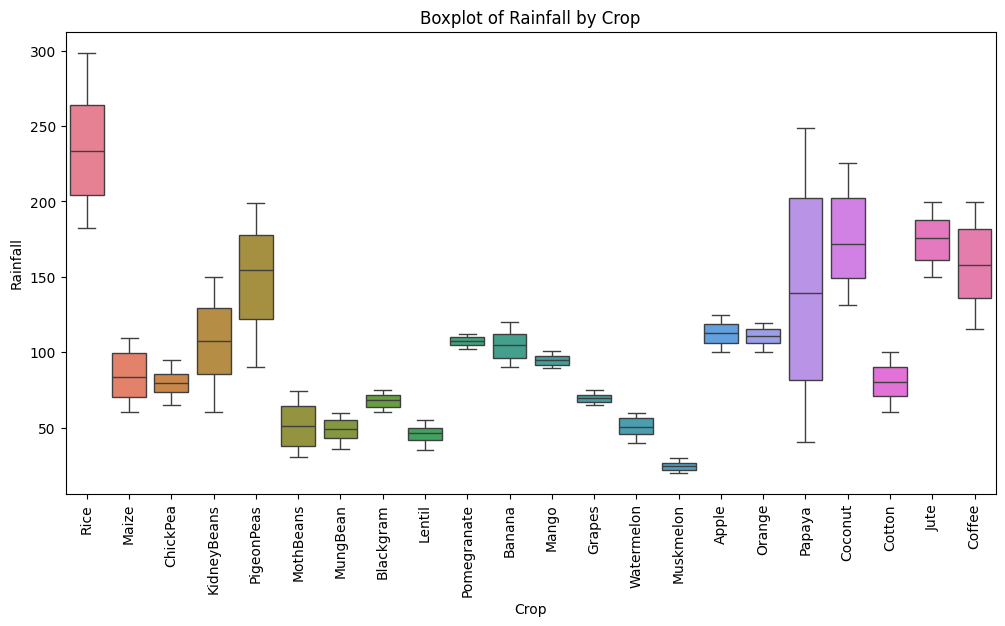

Accuracy: 0.9931818181818182

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        23
           1       1.00      1.00      1.00        21
           2       1.00      1.00      1.00        20
           3       1.00      1.00      1.00        26
           4       1.00      1.00      1.00        27
           5       1.00      1.00      1.00        17
           6       1.00      1.00      1.00        17
           7       1.00      1.00      1.00        14
           8       0.92      1.00      0.96        23
           9       1.00      1.00      1.00        20
          10       0.92      1.00      0.96        11
          11       1.00      1.00      1.00        21
          12       1.00      1.00      1.00        19
          13       1.00      0.96      0.98        24
          14       1.00      1.00      1.00        19
          15       1.00      1.00      1.00        17
          16       1.00    

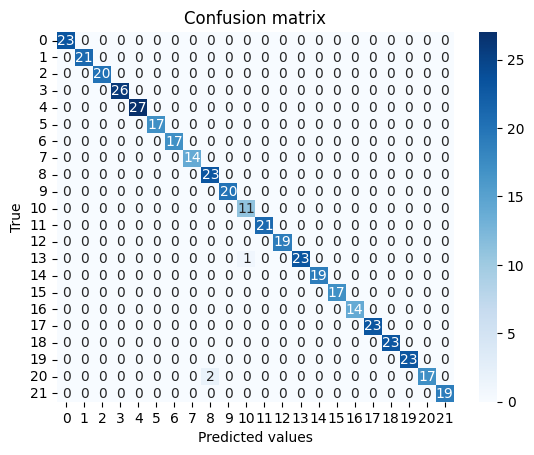

Cross validation scores:
[0.99772727 0.99318182 0.99772727 0.99545455 0.98636364]

Mean cross validation score:0.9940909090909091
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best parameters:
{'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 10, 'criterion': 'gini'}
Model saved successfully!

Crop Recommendation System
1. Predict Crop
2. Suggest Crop Requirements
3. Exit


In [ ]:
# Main function
def main():
  file_path = 'Crop_Recommendation.csv'
  data = load_data(file_path)

  # Data cleaning, EDA and visualization
  clean_data(data)
  perform_eda(data)
  data_visualization(data)

  # Preprocessing
  le, scaler, X, Y = preprocess_data(data)

  # Train model
  rfc = train_model(X, Y)

  #Tune model
  rfc = tune_model(rfc, X, Y)

  # Save model
  pickle.dump(rfc, open('agriTech_model.pkl', 'wb'))
  print("Model saved successfully!")

  # User interface
  while True:
    print("\nCrop Recommendation System")
    print("1. Predict Crop")
    print("2. Suggest Crop Requirements")
    print("3. Exit")
    choice = input("Enter your choice: ")

    if choice == '1':
      crop_prediction(rfc, le)
    elif choice == '2':
      crop_name = input("Enter the crop name: ")
      features = ['Nitrogen', 'Phosphorus', 'Potassium', 'Temperature', 'Humidity', 'pH_Value', 'Rainfall']
      print(f"Optimal range of requirements for {crop_name}:")
      suggest_crop_requirements(crop_name, data, le, features)
    elif choice == '3':
      print('Thank You!')
      break
    else:
      print("Invalid choice. Please enter 1, 2, or 3.")

if __name__ == "__main__":
    main()